In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
hivdr_de = pd.read_csv("../data/processed/hivdr_de_mapping.csv", sep=';')
iap_covariates = pd.read_csv("../data/processed/iap_covariates.csv")
iap_matched = pd.read_csv("../data/processed/iap_fosa_matched.csv")
iap_matched = iap_matched.dropna()
iap_data = pd.read_excel("../IAP_RDC_2010_2016_final.xlsx", sheet_name = "2010_2016")
iap_data = iap_data.dropna(subset=["% Rétention à 12 mois des patients sous TAR de 1ère ligne (cible ≥ 70%)2010-2012/(cible ≥ 90%) 2016"])

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


FileNotFoundError: [Errno 2] No such file or directory: '../IAP_RDC_2010_2016_final.xlsx'

In [4]:
labelled_covariates = iap_covariates.merge(hivdr_de)
full_data = labelled_covariates.merge(iap_matched, left_on = "uidorgunit", right_on = "fosa_id")
full_data = full_data[['monthly', 'quarterly', 'dataelementname', 'catcomboname','population', 
                       'action', 'sub_population', 'province', 'fosa','value']]

In [5]:
def make_sum(data):
    if data.value.iloc[0] in ["true", "false"]:
        out = pd.DataFrame.from_dict({"value":[data.value.iloc[0]]})
    else :
        data.value = data.value.astype(float)
        out = pd.DataFrame.from_dict({"value":[data.value.sum()]})
    return out

full_data = full_data.groupby(["province","fosa","monthly","quarterly", "population","action","sub_population","dataelementname"]).apply(make_sum)

In [6]:
full_data = full_data.reset_index().drop("level_8", 1)
full_data["standard_de"] = full_data["population"] + "_" + full_data["action"]  + "_" + full_data["sub_population"]

In [7]:
iap_data.columns = ['province', 'fosa', 'annee', 'ARV dispensation on time', '12 Months retention on first line', 'Months without stockout',
                    'Correct prescription', 'Virus suppression', 'On time consultation', '12 Month LTFU']
iap_data['12 Month LTFU'] = 100 - iap_data['12 Month LTFU']

In [8]:
targets={'ARV dispensation on time':90,
         '12 Months retention on first line':70,
         'Months without stockout':100,
         'Correct prescription':100,
         'Virus suppression':100,
         'On time consultation':80,
         '12 Month LTFU':20}

In [9]:
iap_data["score"] = 0
for year in list(targets.keys()):
    print(year)
    indics = targets[year]
    year_iap = iap_data.annee == year
    for indic in list(indics.keys()):
        print("   " + indic)
        iap_data.loc[year_iap, "score"] = iap_data.loc[year_iap, "score"] + (pd.to_numeric(iap_data.loc[year_iap, indic], errors = "coerce") >= indics[indic])

ARV dispensation on time


/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


AttributeError: 'int' object has no attribute 'keys'

In [10]:
iap_data["standardized_score"] = iap_data.score / iap_data[list(targets[2016].keys())].apply(lambda x : sum(~pd.isnull(x)), axis = 1)

KeyError: 2016

In [11]:
iap_data.loc[iap_data["ARV dispensation on time"] == 720 , "ARV dispensation on time"] = 72

In [12]:
X = iap_data[["ARV dispensation on time", "12 Months retention on first line", "Months without stockout",'Correct prescription', 
              "score","standardized_score",'province', 'fosa', 'annee']].set_index(['province', 'fosa', 'annee']).apply(pd.to_numeric, errors="coerce" , axis = 1).dropna()

KeyError: "['standardized_score'] not in index"

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X[[X.columns[0], X.columns[1],  X.columns[2],  X.columns[3]]])

NameError: name 'X' is not defined

In [ ]:
X["cluster"] = kmeans.fit_predict(X[[X.columns[0], X.columns[1],  X.columns[2],  X.columns[3]]])
X.groupby("cluster").standardized_score.mean()

In [ ]:
X.boxplot("standardized_score", by = "cluster")

In [ ]:
fig = plt.figure(1, figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[X.columns[0]], X[X.columns[1]], X[X.columns[2]], c=X[X.columns[6]], edgecolor='k', s=100) ; 

In [ ]:
idx = pd.IndexSlice
iap_2016 = X.loc[idx[:, :, 2016],:].reset_index()

In [14]:
useful_variables = full_data[~(full_data.population == "vih_positive") &  
                             ~(full_data.action.str.contains("tb|cv|_ist|dead|cotrim|nut|treatment_supplement|no_treatment_response|counciled_tested")) &
                             ~(full_data.sub_population.str.contains("soutien"))]

In [16]:
useful_variables.columns.values

array(['province', 'fosa', 'monthly', 'quarterly', 'population', 'action',
       'sub_population', 'dataelementname', 'value', 'standard_de'],
      dtype=object)

In [17]:
treat_scheme = ["azt_3tc_lpv_r","tdf_ftc_nvp","abc_3tc_nvp","abc_3tc_efv","azt_3tc_efv","tdf_3tc_efv",
                "tdf_3tc_nvp","tdf_3tc_lpv_r","tdf_ftc_efv","azt_3tc_nvp","abc_3tc_lpv_r","tdf_ftc_lpv_r"]

treatments = useful_variables[useful_variables.sub_population.isin(treat_scheme)]
treatments_fu = treatments.groupby(["province","fosa","monthly","sub_population"]).value.sum().reset_index()
treatments_fu["line"] = 'first_line'
treatments_fu.loc[treatments_fu.sub_population.str.contains("lpv"),"line"] = "second_line"
line_fu = treatments_fu.groupby(["province","fosa","line"]).value.mean().reset_index()
line_fu = line_fu.set_index(["province","fosa"]).pivot(columns = "line")["value"].reset_index()

In [1079]:
X

,cmm,value,first_line,second_line
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,1.000000,1.000000,7.916667,0.250000
3,0.000000,0.000000,0.000000,0.000000
4,24.750000,24.750000,15.750000,0.000000
5,403.366667,403.366667,14.041667,0.000000
6,1231.666667,1231.666667,141.666667,0.250000
7,600.000000,600.000000,10.750000,0.000000
8,6900.000000,6900.000000,4.416667,0.000000
9,1185.720227,1185.720227,42.000000,0.083333


In [987]:
pdv_data = useful_variables[(useful_variables.action == "pdv")]
pdv_data.value = pd.to_numeric(pdv_data.value)
pdv_data = pdv_data.groupby(["province","fosa"]).value.mean().reset_index()
pdv_data.columns = ["province", "fosa", "n_pdv"]

In [951]:
pvvih_data = useful_variables[(useful_variables.population == "pvvih") & (useful_variables.action == "enrolled_hiv_services")]
pvvih_data.value = pd.to_numeric(pvvih_data.value)
pvvih_data = pvvih_data.groupby(["province","fosa"]).value.mean().reset_index()
pvvih_data.columns = ["province", "fosa", "n_pvvih"]

In [975]:
stock_out_data = useful_variables[useful_variables.action == "rupture_stock_mois"]
def stock_out_prob(data):    
    return sum(data == "true") / len(data)


stock_out_data = stock_out_data.groupby(["province","fosa"]).value.apply(stock_out_prob).reset_index()
stock_out_data.columns = ["province", "fosa", "stockout_perc"]

In [989]:
cmm_data = useful_variables[useful_variables.action == "cmm_mois"]

cmm_data = cmm_data.groupby(["province","fosa","monthly"]).value.sum().reset_index().groupby(["province","fosa"]).value.sum().reset_index()
cmm_data.columns = ["province", "fosa", "cmm"]

In [1107]:
covariables = cmm_data.merge(stock_out_data).merge(line_fu).merge(pdv_data)#.merge(pvvih_data)#.merge(pdv_data)#.merge(line_fu
print(len(covariables))

63


In [872]:
fd = useful_variables[["province","fosa","monthly","quarterly", "standard_de","value"]].drop_duplicates()
fd = fd.drop_duplicates(["province","fosa","monthly","quarterly", "standard_de"], keep = False)
fd = fd.set_index(["province","fosa","monthly","quarterly"]).pivot(columns="standard_de")

In [873]:
data_2017 = fd.loc[idx[:,:,:,["2017Q1","2017Q2","2017Q3","2017Q4"]],"value"].reset_index(col_level=1)

In [874]:
iap_2016.province = iap_2016.province.str.lower()
iap_2016.fosa = iap_2016.fosa.str.lower()

In [1108]:
model_data = covariables.merge(iap_2016)

In [1109]:
len(model_data)

47

In [1110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [1120]:
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

In [1134]:
def get_ppv(data):
    n = len(data)
    predicted = data.predicted.sum()
    return pd.DataFrame.from_dict({"n":[n],"predicted":[predicted]})

y_out.groupby("standardized_score").apply(get_ppv).reset_index(drop = True)

,n,predicted
0,11,11
1,4,0


In [1111]:
y = model_data.standardized_score < .5
X = model_data[['cmm', 'value', 'first_line', 'second_line']]

scores = pd.DataFrame()
for i in range(100):
    print(i)
    for name, clf in zip(names, classifiers):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
        clf.fit(X_train, y_train)
        clf.predict(X_test)
        score = {"algo":name, "score":[clf.score(X_test, y_test)]}
        scores = scores.append(pd.DataFrame.from_dict(score), sort = True)
        predicted = clf.predict(X_test) == y_test
        y_out = pd.DataFrame(y_test)
        y_out["predicted"] = predicted
        y_out.columns = ["class", "predicted"]
        ppvs = y_out.groupby("standardized_score").apply(get_ppv).reset_index()

scores["target"] = "< 50% EWI targets reached"

0


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


1


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


3


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


4


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


5


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


6


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


7


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


8


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


9


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


10


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


11


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


12


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


13


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


14


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


15


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


16


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


17


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


18


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


19


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


20


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


21


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


22


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


23


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


24


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


25


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


26


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


27


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


29


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


30


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


31


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


32


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


33


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


34


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


35
36


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


37


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


38


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


39


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


40


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


41


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


42


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


43


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


44


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


45


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


46


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


47


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


48


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


49


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


50


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


51


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


52


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


53


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


54


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


55


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


56


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


57


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


58


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


59


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


60


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


61


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


62


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


63


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


64


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


65


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


66


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


67


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


68


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


69


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


70


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


71


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


72


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


73


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


74


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


75


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


76


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


77


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


78


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


79


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


80


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


81


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


82


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


83


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


84


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


85


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


86


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


87


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


88


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


89


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


90


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


91


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


92


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


93


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


94


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


95


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


96


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


97


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


98


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


99


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [1112]:
y = model_data.cluster
X = model_data[['cmm', 'value', 'first_line', 'second_line']]

for i in range(100):
    print(i)
    for name, clf in zip(names, classifiers):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
        try :
            clf.fit(X_train, y_train)
            score = {"algo":name, "score":[clf.score(X_test, y_test)], 'target':"k-mean cluster"}
            scores = scores.append(pd.DataFrame.from_dict(score), sort = True)
        except :
            print("Didn't work this time")

0


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
1


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2
Didn't work this time
3


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
4


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


5


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
6


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
7


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
8


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
9


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
10


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
11


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
12


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


13


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
14


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


15


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


16


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
17


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


18


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
19


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
20


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
21


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
22


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
23


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
24


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
25


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
26


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
27


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
28


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


29


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
30


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
31


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


32


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
33


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


34


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
35


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
36


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
37


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
38


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
39


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


40


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
41


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
42


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
43


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
44


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
45


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
46
Didn't work this time
47


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
48


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
49


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


50


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


51


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
52


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
53


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


54


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
55


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
56


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
57


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
58


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
59


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


60


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


61


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
62


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
63


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
64


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
65


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
66


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
67


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


68


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
69


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
70


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
71


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
72


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
73


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
74


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


75


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
76


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
77


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
78


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
79


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
80


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
81


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
82


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
83


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
84


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
85


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


86


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
87


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
88


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
89


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
90


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
91


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
92


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


93


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
94


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
95


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


96


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


97


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
98


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Didn't work this time
99
Didn't work this time


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


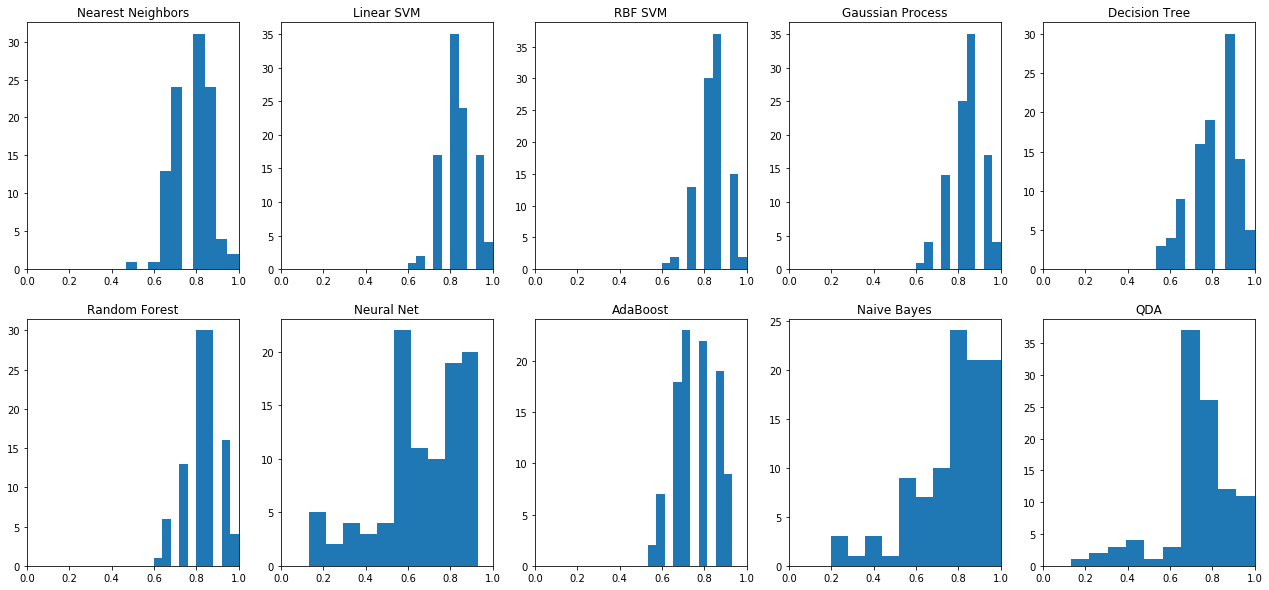

In [1113]:
figure = plt.figure(figsize=(22, 10))
plot_data = scores[scores.target == scores.target.unique()[0]]
for i in range(10):
    algo = scores.algo.unique()[i]
    sb_data = plot_data.score[plot_data.algo == algo]
    ax = plt.subplot(2, 5, i + 1)
    ax.hist(sb_data)
    ax.set_title(algo)
    ax.set_xlim(0,1)

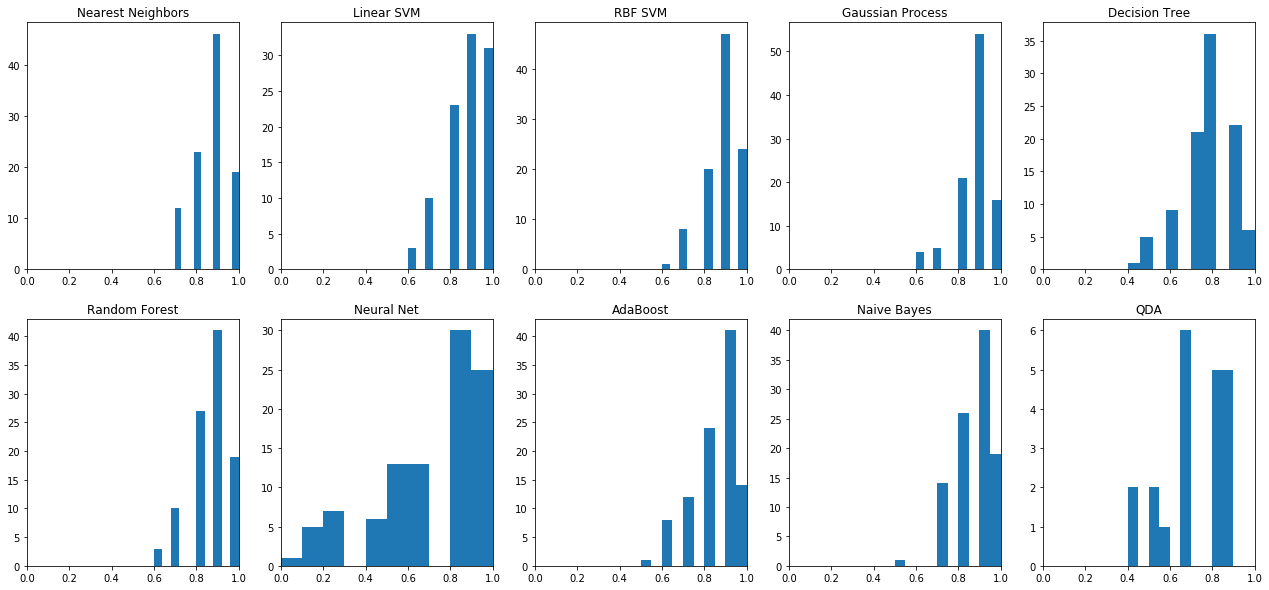

In [1114]:
figure = plt.figure(figsize=(22, 10))
plot_data = scores[scores.target == scores.target.unique()[1]]
for i in range(10):
    algo = scores.algo.unique()[i]
    sb_data = plot_data.score[plot_data.algo == algo]
    ax = plt.subplot(2, 5, i + 1)
    ax.hist(sb_data)
    ax.set_title(algo)
    ax.set_xlim(0,1)